# TinyHiera with multiloader

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '8'

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from tqdm import tqdm
from einops import rearrange
from torch.optim import AdamW, Adam

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict
from experanto.datasets import ChunkDataset, SimpleChunkedDataset
from experanto.utils import LongCycler, MultiEpochsDataLoader
from experanto.dataloaders import get_multisession_dataloader


In [3]:
paths = ['dynamic29513-3-5-Video-full',
         'dynamic29514-2-9-Video-full',
         'dynamic29755-2-8-Video-full',
         'dynamic29647-19-8-Video-full',
         'dynamic29156-11-10-Video-full',
         'dynamic29623-4-9-Video-full',
         'dynamic29515-10-12-Video-full',
         'dynamic29234-6-9-Video-full',
         'dynamic29712-5-9-Video-full',
         'dynamic29228-2-10-Video-full'
        ]
full_paths = [path.join("/data/mouse_polly/", f) for f in paths]

## Load Config Object from .yaml file

### Modify the config

In [8]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}
cfg.dataset.modality_config.screen.transforms.Resize.size = [72, 128]

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True

### Instantiate MultiDataloader

In [9]:
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths, cfg)

# Hiera

In [13]:
import torch
from hiera import Hiera
tiny_hiera = Hiera(input_size=(16,72, 128),
                     num_heads=1, 
                     stages=(4, 8), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(1, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 8, 8),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)
#tiny_hiera = torch.compile(tiny_hiera).cuda().to(torch.bfloat16);
tiny_hiera = tiny_hiera.cuda().to(torch.bfloat16);

In [147]:
example_in = torch.ones(8,1,16,72, 128).to("cuda", torch.bfloat16)
out = tiny_hiera(example_in, return_intermediates=True);
features = out[-1][-1]
features.shape

torch.Size([8, 8, 9, 16, 192])

In [8]:
example_in = torch.ones(8,1,16,144, 256).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = tiny_hiera(example_in, return_intermediates=True);

100% 100/100 [00:01<00:00, 75.07it/s]


In [10]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = tiny_hiera(videos, return_intermediates=True);
        if i > 200:
            break

201it [00:13, 14.63it/s]


In [18]:
32*15*16

7680

In [ ]:
videos

In [17]:
class IndexedLinearReadout(nn.Module):
    """
    Readout module for MTM models with selectable weights based on 
    input IDs. Based on :class:`torch.nn.Linear`.
    """
    def __init__(
        self,
        unique_ids: int,
        in_features: int = 384,
        out_features: int = 1,
        bias: bool = True,
        device="cuda",
        dtype=torch.float32,
        init_std: float = 0.02,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.unique_ids = unique_ids
        self.in_features = in_features
        self.out_features = out_features
        self.init_std = init_std

        self.query = nn.Parameter(
            torch.empty(1, 4, unique_ids, 32, **factory_kwargs)
        )
        self.weight = nn.Parameter(
            torch.empty(unique_ids, in_features, out_features, **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.empty(1, unique_ids, out_features, **factory_kwargs)
            )
        else:
            self.register_parameter('bias', None)
        self.init_weights()

    def init_weights(self, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.weight,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.query,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        if self.bias is not None:
            self.bias.data.zero_()

In [18]:
class ELU1(nn.Module):
    """
    Adapted from `NeuralPredictors <https://github.com/sinzlab/neuralpredictors/blob/main/neuralpredictors/layers/activations.py>`__.
    
    Elu activation function shifted by 1 to ensure that the
    output stays positive. That is:
    Elu1(x) = Elu(x) + 1
    """

    def forward(self, x, inplace=False, eps=0.0):
        return F.elu(x, inplace=inplace) + 1.0 + eps

In [19]:
class MouseHieraSmall(nn.Module):
    def __init__(self,
                 backbone,
                 dls,
                 t=16,
                 dim=512,
                 dim_head=32,
                 num_heads=4):
        super().__init__()
        self.backbone=backbone
        self.num_heads=num_heads
        self.dim_head=dim_head
        self.wk = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wv = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.neuron_proj = nn.Linear(dim_head * num_heads, t, bias=False)
        self.readout = nn.ModuleDict()
        self.activation = ELU1()
        for k, v in dls.loaders.items():
            n_neurons = next(iter(v))["responses"].shape[-1]
            self.readout[k] = IndexedLinearReadout(n_neurons, in_features=dim_head*num_heads, out_features=1)
    
    def forward(self, x, key):
        x = self.backbone(x, return_intermediates=True)[1][-1]
        b, t, h, w, d = x.shape
        seq_len = t*h*w
        x = x.view(b, -1, d)
        k, v = self.wk(x), self.wv(x)
        q = self.readout[key].query
        n = q.shape[2]
        q = q.tile(b, 1, 1, 1)
        k = k.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        v = v.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
            o = F.scaled_dot_product_attention(q, k, v)
        o = o.transpose(1,2).contiguous().view(b, -1, self.num_heads * self.dim_head)
        o = self.neuron_proj(o) # (B, N, D) -> (B, N, t)
        o = o + r.readout[key].bias
        o = F.elu(o, inplace=True) + 1.0
        return o

In [20]:
features[-1][-1].shape[-1]

192

In [21]:
backbone_dim = features[-1][-1].shape[-1]
r = MouseHieraSmall(tiny_hiera, train_dl, 16, backbone_dim, dim_head=32,num_heads=4)
#opt_r = torch.compile(r, )
opt_r = r

In [22]:
torch.set_float32_matmul_precision('high')
opt_r.backbone.to(torch.bfloat16).cuda();
opt_r = opt_r.train().to(torch.bfloat16).cuda()
opt_r = opt_r.cuda().to(torch.bfloat16)
opt_r = torch.compile(r).cuda().to(torch.bfloat16)

In [23]:
k, b = next(iter(train_dl))
videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
out = opt_r(videos, k);

In [24]:
out.shape

torch.Size([32, 7671, 16])

In [25]:
r.readout[k].weight.shape

torch.Size([7671, 128, 1])

In [27]:
criteria = nn.PoissonNLLLoss(log_input=False, reduction='mean')
opt = Adam(opt_r.parameters(), lr=1e-3, fused=True)
import pytorch_warmup as warmup
from torch.amp import autocast
warmup_scheduler = warmup.UntunedLinearWarmup(opt, )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 1e6, eta_min=1e-7)


In [28]:
opt.param_groups[0]['lr']

5.002501250625313e-07

In [149]:
opt_r.backbone.pos_embed_temporal.shape

torch.Size([1, 8, 96])

In [150]:
opt_r.readout[k].query.shape

torch.Size([1, 4, 7939, 32])

In [ ]:
losses, corrs, lrs = [], [], []
for train_loop in range(250):
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        #with autocast(device_type='cuda', dtype=torch.bfloat16):
        #    out = opt_r(videos, k);
        #    loss = criteria(out.transpose(1,2), responses)
        out = opt_r(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(opt_r.parameters(), max_norm=1.0, norm_type=2)
        opt.step()

        
        opt.zero_grad()
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
            print(opt.param_groups[0]['lr'])
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()

1it [00:11, 11.56s/it]

0.004104885262860672
1.000500250122594e-06


8it [02:31, 19.70s/it]W1016 15:25:33.548000 88681 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1016 15:25:33.548000 88681 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/tmp/ipykernel_88681/1382549279.py:22)
W1016 15:25:33.548000 88681 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: L['key'] == '29513-3-5'                                     
W1016 15:25:33.548000 88681 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1016 15:25:33.548000 88681 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
102it [02:39, 10.38it/s]

0.019278256439801453
5.10255114721966e-05


202it [02:48, 10.06it/s]

0.021783629687059176
0.00010105051519036971


302it [02:57, 10.12it/s]

0.007919186442534335
0.00015107550399947792


402it [03:06, 10.39it/s]

0.007293178695351527
0.0002011004704943595


502it [03:14, 10.15it/s]

0.01664661886433572
0.00025112540726985645


602it [03:23, 10.13it/s]

0.04187299147230347
0.00030115030692081556


702it [03:32, 10.17it/s]

0.07549852520705332
0.0003511751620420897


802it [03:41,  9.95it/s]

0.10090639314559441
0.0004011999652285392


902it [03:50, 10.35it/s]

0.11573168720497393
0.00045122470907503313


1002it [03:59, 10.07it/s]

0.11477264505316863
0.0005012493861764506


1102it [04:08, 10.24it/s]

0.11916788265101363
0.0005512739891276802


1202it [04:16, 10.05it/s]

0.12767889614217098
0.0006012985105236241


1302it [04:25, 10.34it/s]

0.1222128221905572
0.0006513229429591978


1402it [04:34, 10.17it/s]

0.13220366247382198
0.0007013472790293314


1502it [04:43, 10.22it/s]

0.12603159430162883
0.0007513715113289696


1602it [04:52,  9.90it/s]

0.1374733741423347
0.0008013956324530766


1702it [05:01,  9.96it/s]

0.12649082641326967
0.0008514196349966324


1802it [05:09, 10.24it/s]

0.13026024892972227
0.0009014435115546369


1902it [05:18, 10.11it/s]

0.12753337513213459
0.0009514672547221117


2002it [05:27, 10.22it/s]

0.12982176390238043
0.0009999901215440093


2020it [05:29,  6.14it/s]
3it [00:00,  8.68it/s]

0.12240490175564471
0.0009999899230874326


103it [00:09, 10.47it/s]

0.12952396433267924
0.0009999889011993108


203it [00:18, 10.81it/s]

0.13783287575234476
0.000999987829969197


303it [00:26, 10.62it/s]

0.14740923942350181
0.0009999867093971977


403it [00:35, 10.62it/s]

0.14295841817535387
0.0009999855394834238


503it [00:44, 10.71it/s]

0.13205020264557718
0.0009999843202279902


603it [00:53, 10.82it/s]

0.14123912150918286
0.0009999830516310168


703it [01:02, 10.88it/s]

0.1500278287090296
0.00099998173369263


803it [01:11, 10.38it/s]

0.15234745818311834
0.000999980366412959


903it [01:19, 10.16it/s]

0.1399736521658245
0.0009999789497921387


1003it [01:28, 10.54it/s]

0.14968842833842444
0.0009999774838303091


1103it [01:37, 10.68it/s]

0.14294990975384106
0.0009999759685276157


1203it [01:46, 10.70it/s]

0.14575488937363643
0.0009999744038842063


1303it [01:55, 10.61it/s]

0.13533039864639207
0.000999972789900238


1403it [02:04, 10.75it/s]

0.14244573277141057
0.0009999711265758669


1503it [02:12, 10.70it/s]

0.14418313005645247
0.0009999694139112584


1603it [02:21, 10.88it/s]

0.1316396040986751
0.0009999676519065832


1703it [02:30, 10.14it/s]

0.13727984910340826
0.0009999658405620132


1803it [02:39, 10.84it/s]

0.14290887820207926
0.0009999639798777273


1903it [02:48, 10.61it/s]

0.1331201825833116
0.0009999620698539098


2003it [02:57, 10.75it/s]

0.14768272296224239
0.0009999601104907503


2020it [02:58, 11.31it/s]
3it [00:00,  8.94it/s]

0.14529498394973506
0.0009999597126974142


103it [00:09, 10.73it/s]

0.1500898717426684
0.0009999576941272974


203it [00:18, 10.75it/s]

0.14947142222715162
0.0009999556262182696


303it [00:26, 10.67it/s]

0.145610899547794
0.0009999535089705322


403it [00:35, 10.51it/s]

0.14614700369539002
0.0009999513423842987


503it [00:44, 10.66it/s]

0.14797683167334033
0.0009999491264597816


603it [00:53, 10.61it/s]

0.13942443606491406
0.0009999468611971982


703it [01:02, 10.52it/s]

0.15386513755588033
0.0009999445465967722


803it [01:11, 10.61it/s]

0.1448565087995313
0.0009999421826587323


903it [01:20, 10.42it/s]

0.14826239258139895
0.0009999397693833119


1003it [01:29, 10.77it/s]

0.13840653502517733
0.000999937306770749


1103it [01:38, 10.55it/s]

0.13714687820044136
0.0009999347948212874


1203it [01:46, 10.67it/s]

0.1477073590920576
0.0009999322335351754


1303it [01:55, 10.67it/s]

0.14087086177024208
0.0009999296229126636


1403it [02:04, 10.89it/s]

0.13381912365224566
0.0009999269629540112


1503it [02:13, 10.56it/s]

0.13668775905282934
0.00099992425365948


1603it [02:22, 10.62it/s]

0.12900812771929904
0.000999921495029339


1703it [02:31, 10.73it/s]

0.134947080981665
0.000999918687063859


1803it [02:40, 10.52it/s]

0.1450098113270967
0.0009999158297633148


1903it [02:48, 10.76it/s]

0.14609809810263866
0.0009999129231279928


2003it [02:57, 10.78it/s]

0.13446560271761468
0.0009999099671581784


2020it [02:59, 11.27it/s]
3it [00:00,  9.36it/s]

0.13546421849562706
0.0009999093700441023


103it [00:09, 10.68it/s]

0.1473247474150455
0.0009999063548732827


203it [00:18, 10.25it/s]

0.1475102402172817
0.000999903290368619


303it [00:26, 10.84it/s]

0.1440955154014426
0.000999900176530413


403it [00:35, 10.43it/s]

0.13402127111034454
0.0009998970133589732


503it [00:44, 10.79it/s]

0.13519031523039202
0.00099989380085461


603it [00:53, 10.85it/s]

0.13965039129722764
0.0009998905390176404


703it [01:02, 10.70it/s]

0.12620710450759814
0.000999887227848389


803it [01:11, 10.70it/s]

0.1439528221349362
0.0009998838673471804


903it [01:19, 10.77it/s]

0.14911121947513842
0.0009998804575143472


1003it [01:28, 10.73it/s]

0.13434411937431362
0.0009998769983502256


1103it [01:37, 10.38it/s]

0.137924608253774
0.0009998734898551563


1203it [01:46, 10.54it/s]

0.15248250842047825
0.0009998699320294855


1303it [01:55, 10.51it/s]

0.14389328184775776
0.0009998663248735667


1403it [02:04, 10.35it/s]

0.13806287044384905
0.0009998626683877538


1503it [02:13, 10.76it/s]

0.14000584028336593
0.0009998589625724085


1603it [02:21, 10.73it/s]

0.1385963537695184
0.000999855207427895


1703it [02:30, 10.56it/s]

0.14189016753864525
0.0009998514029545857


1803it [02:39, 10.83it/s]

0.14106677712886231
0.0009998475491528559


1903it [02:48, 10.64it/s]

0.14499465722534466
0.000999843646023085


2003it [02:57, 10.69it/s]

0.14184516073511136
0.0009998396935656582


2020it [02:58, 11.31it/s]
3it [00:00,  9.10it/s]

0.13768682649112257
0.0009998388971548884


103it [00:09, 10.80it/s]

0.14150736560254898
0.0009998348855047921


203it [00:17, 10.79it/s]

0.1459398287204411
0.000999830824527905


303it [00:26, 10.91it/s]

0.13313293777849214
0.0009998267142246288


403it [00:35, 10.65it/s]

0.13603542732215373
0.0009998225545953664


503it [00:44, 10.81it/s]

0.1386030307328166
0.0009998183456405327


603it [00:53, 10.91it/s]

0.13991238784511942
0.0009998140873605386


703it [01:02, 10.63it/s]

0.13904710841918028
0.0009998097797558063


803it [01:10, 10.67it/s]

0.13833335293880422
0.000999805422826764


903it [01:19, 10.77it/s]

0.1442333833425872
0.000999801016573838


1003it [01:28, 10.74it/s]

0.1396183188530304
0.000999796560997463


1103it [01:37, 10.75it/s]

0.14137666250419784
0.000999792056098079


1203it [01:46, 10.72it/s]

0.14092430285812205
0.0009997875018761323


1303it [01:55, 10.63it/s]

0.1407122104434083
0.0009997828983320718


1403it [02:03, 10.82it/s]

0.1323993575871293
0.0009997782454663519


1503it [02:12, 10.26it/s]

0.14002516441454288
0.0009997735432794334


1603it [02:21, 10.35it/s]

0.13638234302782853
0.0009997687917717769


1703it [02:30, 10.65it/s]

0.1368590327672231
0.0009997639909438518


1803it [02:39, 10.70it/s]

0.14619019391400753
0.0009997591407961337


1903it [02:48, 10.41it/s]

0.13843083445777318
0.0009997542413290991


2003it [02:56, 10.65it/s]

0.14268916392473624
0.0009997492925432336


2020it [02:58, 11.33it/s]
3it [00:00,  9.15it/s]

0.1411486347652552
0.0009997482968678434


103it [00:09, 10.38it/s]

0.15146179631194115
0.000999743288900026


203it [00:17, 10.83it/s]

0.14718914856350018
0.000999738231614459


303it [00:26, 10.46it/s]

0.15502214218857818
0.0009997331250116402


403it [00:35, 10.89it/s]

0.1500307088358989
0.0009997279690920743


503it [00:44, 10.72it/s]

0.14252458592127365
0.0009997227638562694


603it [00:53, 10.69it/s]

0.1454614963909074
0.0009997175093047399


703it [01:02, 10.83it/s]

0.13012833751460143
0.0009997122054380039


803it [01:10, 10.88it/s]

0.13421315515908017
0.0009997068522565853


903it [01:19, 10.54it/s]

0.13698480967385088
0.0009997014497610127


1003it [01:28, 10.67it/s]

0.14294098634615973
0.0009996959979518187


1103it [01:37, 10.42it/s]

0.14511248798289883
0.0009996904968295431


1203it [01:46, 10.76it/s]

0.14387017363465476
0.0009996849463947276


1303it [01:55, 10.91it/s]

0.14637357443490945
0.0009996793466479194


1403it [02:03, 10.68it/s]

0.14189267445907663
0.0009996736975896702


1503it [02:12, 10.69it/s]

0.15029010156173106
0.0009996679992205408


1603it [02:21, 10.71it/s]

0.14949109846087952
0.0009996622515410921


1703it [02:30, 10.96it/s]

0.1458447009058588
0.0009996564545518905


1803it [02:39, 10.55it/s]

0.14712471433401844
0.000999650608253508


1903it [02:48, 10.70it/s]

0.14619564892254358
0.000999644712646522


2003it [02:56, 10.67it/s]

0.14434620487583139
0.0009996387677315157


2020it [02:58, 11.33it/s]
3it [00:00,  9.38it/s]

0.14557651221676016
0.0009996375728316032


103it [00:09, 10.65it/s]

0.1393788400381536
0.0009996315687477453


203it [00:18, 10.79it/s]

0.144065650152127
0.000999625515357164


303it [00:26, 10.66it/s]

0.15177707175576424
0.0009996194126604568


403it [00:35, 10.97it/s]

0.1402118891608162
0.000999613260658225


503it [00:44, 10.60it/s]

0.14764661960788839
0.0009996070593510761


603it [00:53, 10.82it/s]

0.1482149382818267
0.000999600808739621


703it [01:02, 10.89it/s]

0.1514725782098529
0.0009995945088244786


803it [01:10, 10.75it/s]

0.1424778705346487
0.000999588159606269


903it [01:19, 10.81it/s]

0.1546870452384677
0.0009995817610856212


1003it [01:28, 10.49it/s]

0.13801272693311156
0.000999575313263163


1103it [01:37, 10.63it/s]

0.15026097927053148
0.000999568816139534


1203it [01:46, 10.84it/s]

0.1440338304032121
0.0009995622697153747


1303it [01:55, 10.96it/s]

0.1450999153680312
0.0009995556739913303


1403it [02:03, 10.68it/s]

0.14670719931810214
0.0009995490289680525


1503it [02:12, 10.65it/s]

0.135576829399738
0.0009995423346461968


1603it [02:21, 10.95it/s]

0.14031070646526833
0.0009995355910264235


1703it [02:30, 10.58it/s]

0.13840993556644657
0.0009995287981093984


1803it [02:39, 10.75it/s]

0.14355981079973176
0.0009995219558957928


1903it [02:48, 10.58it/s]

0.1454325898459914
0.0009995150643862822


2003it [02:56, 10.78it/s]

0.14616023083909607
0.0009995081235815446


2020it [02:58, 11.32it/s]
3it [00:00,  8.94it/s]

0.14905767963410071
0.000999506729505231


103it [00:09, 10.61it/s]

0.14666491200012335
0.000999499729547129


203it [00:18, 10.60it/s]

0.1402043975640878
0.0009994926802953151


303it [00:26, 10.42it/s]

0.14150005087171574
0.0009994855817504849


403it [00:35, 10.62it/s]

0.13330936106854352
0.0009994784339133382


503it [00:44, 10.73it/s]

0.14138296442080583
0.0009994712367845811


603it [00:53, 10.63it/s]

0.14405382234476208
0.0009994639903649237


703it [01:02, 10.75it/s]

0.14414234603750045
0.0009994566946550818


803it [01:11, 10.72it/s]

0.1383926602210406
0.000999449349655775


903it [01:19, 10.81it/s]

0.13759407089015255
0.000999441955367729


1003it [01:28, 10.62it/s]

0.1390533339483016
0.0009994345117916733


1103it [01:37, 10.53it/s]

0.1445378580786792
0.0009994270189283407


1203it [01:46, 10.75it/s]

0.15086853037124826
0.000999419476778473


1303it [01:55, 10.78it/s]

0.13898641620897648
0.0009994118853428144


1403it [02:04, 10.70it/s]

0.12727928530461635
0.000999404244622112


1503it [02:12, 10.70it/s]

0.15385158252250591
0.0009993965546171235


1603it [02:21, 10.67it/s]

0.1398459788901874
0.0009993888153286045


1703it [02:30, 10.72it/s]

0.13744302124058214
0.0009993810267573207


1803it [02:39, 11.07it/s]

0.13639728824711522
0.0009993731889040406


1903it [02:48, 10.67it/s]

0.1433613032027122
0.0009993653017695365


2003it [02:57, 10.56it/s]

0.13790917534229832
0.0009993573653545881


2020it [02:58, 11.31it/s]
3it [00:00,  9.22it/s]

0.13700202552919133
0.000999355772158014


103it [00:09, 10.83it/s]

0.14272565288446815
0.0009993477766075667


203it [00:18, 10.74it/s]

0.13635500323300034
0.0009993397317784043


303it [00:26, 10.60it/s]

0.14420608512618038
0.0009993316376713213


403it [00:35, 10.85it/s]

0.15253278154070488
0.0009993234942871155


503it [00:44, 10.77it/s]

0.14714383867952857
0.000999315301626592


603it [00:53, 10.79it/s]

0.1361927962679129
0.0009993070596905592


703it [01:02, 10.85it/s]

0.1518750945771115
0.0009992987684798304


803it [01:11, 10.51it/s]

0.14220583468168888
0.000999290427995223


903it [01:19, 10.78it/s]

0.14131465018108627
0.0009992820382375602


1003it [01:28, 10.72it/s]

0.14410310931293605
0.0009992735992076698


1103it [01:37, 10.73it/s]

0.14171465518984297
0.0009992651109063874


1203it [01:46, 10.61it/s]

0.14252685791422673
0.0009992565733345463


1303it [01:55, 10.86it/s]

0.14466546182602752
0.0009992479864929917


1403it [02:03, 10.77it/s]

0.13538009758299904
0.0009992393503825729


1503it [02:12, 10.79it/s]

0.14915846143135789
0.0009992306650041393


1603it [02:21, 10.85it/s]

0.14129165367069255
0.0009992219303585493


1703it [02:30, 10.89it/s]

0.14397151913916478
0.0009992131464466654


1803it [02:39, 10.42it/s]

0.1507217446776418
0.0009992043132693539


1903it [02:48, 10.65it/s]

0.151977135892741
0.0009991954308274863


2003it [02:56, 10.75it/s]

0.14710608814455847
0.0009991864991219408


2020it [02:58, 11.33it/s]
3it [00:00,  9.75it/s]

0.14601808705445096
0.0009991847068692675


103it [00:09, 10.86it/s]

0.14166776401655934
0.0009991757160484707


203it [00:17, 10.85it/s]

0.13483110978567425
0.0009991666759659413


303it [00:26, 10.76it/s]

0.145214067962569
0.000999157586622571


403it [00:35, 10.65it/s]

0.14271042320411687
0.0009991484480192567


503it [00:44, 10.77it/s]

0.1407782072272558
0.0009991392601569004


603it [00:53, 10.67it/s]

0.15812639630278424
0.0009991300230364094


703it [01:02, 10.59it/s]

0.14673898676052927
0.0009991207366586937


803it [01:10, 10.55it/s]

0.14152652995163867
0.0009991114010246712


903it [01:19, 10.83it/s]

0.13808865627909592
0.0009991020161352628


1003it [01:28, 10.87it/s]

0.1554221576045155
0.0009990925819913963


1103it [01:37, 10.63it/s]

0.13726005459999271
0.0009990830985940012


1203it [01:46, 10.55it/s]

0.15268467304775277
0.0009990735659440142


1303it [01:54, 10.55it/s]

0.1440804206884556
0.0009990639840423755


1403it [02:03, 10.40it/s]

0.1469164601040221
0.0009990543528900309


1503it [02:12, 10.87it/s]

0.1486441088814003
0.0009990446724879316


1603it [02:21, 10.65it/s]

0.14528238080392378
0.000999034942837032


1703it [02:30, 10.73it/s]

0.13970023814427612
0.0009990251639382932


1803it [02:39, 10.52it/s]

In [143]:
250*2000

500000

In [142]:
len(corrs)

50500

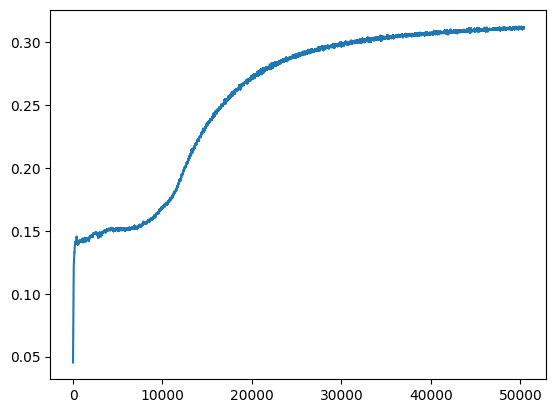

In [140]:
plt.plot(np.convolve(corrs, [1]*100, "valid")/100, )

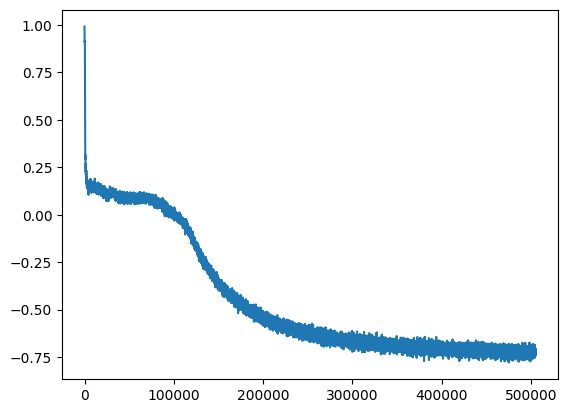

In [31]:
plt.plot(np.convolve(losses, [1]*100, "valid")/100, )

In [80]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=False
cfg.dataset.modality_config.screen.sample_stride=16
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True

### Instantiate MultiDataloader

In [123]:
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths[8:9], cfg)

In [124]:
targets, predictions = [],[]
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        out = opt_r(videos, k);
        predictions.append(out.transpose(1,2).to(torch.float32).cpu().numpy())
        targets.append(responses.to(torch.float32).cpu().numpy())

50it [00:07,  6.58it/s]


In [125]:
r1 = np.vstack(np.vstack(predictions))

In [126]:
r2 = np.vstack(np.vstack(targets))

In [122]:
r1.std()

np.float32(1.4505415)

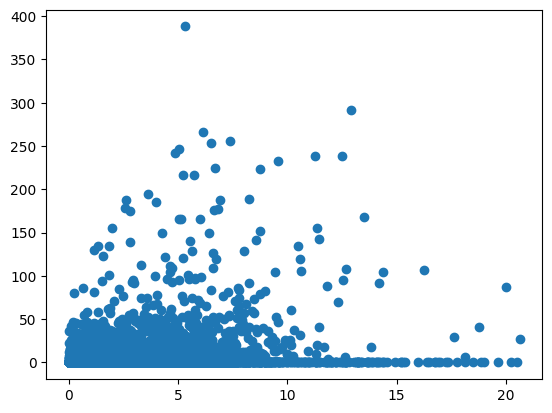

In [139]:
n=3000

plt.scatter(r1[:,n], r2[:,n])

In [116]:
cs = []
for n in range(5000):
    c =  np.corrcoef(r1[...,n].flatten(), r2[...,n].flatten(), )[0,1]
    cs.append(c)

In [141]:
np.stack(cs).mean()

np.float64(0.2415144713332901)

In [42]:
torch.save(opt_r.state_dict(), "small_hiera_1016.pth")

# Another 200 steps

In [ ]:
for train_loop in range(200):
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        #with autocast(device_type='cuda', dtype=torch.bfloat16):
        #    out = opt_r(videos, k);
        #    loss = criteria(out.transpose(1,2), responses)
        out = opt_r(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(opt_r.parameters(), max_norm=1.0, norm_type=2)
        opt.step()

        
        opt.zero_grad()
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()

1it [00:00,  2.82it/s]

0.2493495497672485


101it [00:28,  3.36it/s]

0.24698720524257822


201it [00:55,  3.37it/s]

0.2548009030297455


301it [01:23,  3.37it/s]

0.25241333779929065


331it [01:32,  3.40it/s]

In [29]:
losses, corrs = [], []
for _ in tqdm(range(200)):
    
    videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
    responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    with autocast("cuda", )
        out = opt_r.generate(videos, k);
    loss = criteria(out.transpose(1,2), responses)
    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()
    opt.zero_grad()
    losses.append(loss.item())
    neuron=0
    r2 = responses.to(torch.float32).cpu().numpy().flatten()
    r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
    corrs.append(np.corrcoef(r1,r2)[0,1].item())

  0% 0/500 [00:00<?, ?it/s]


RuntimeError: "_amp_foreach_non_finite_check_and_unscale_cuda" not implemented for 'BFloat16'

## Overfitting

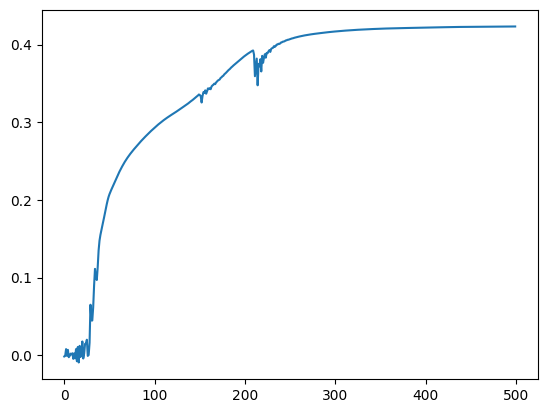

In [16]:
plt.plot(corrs)

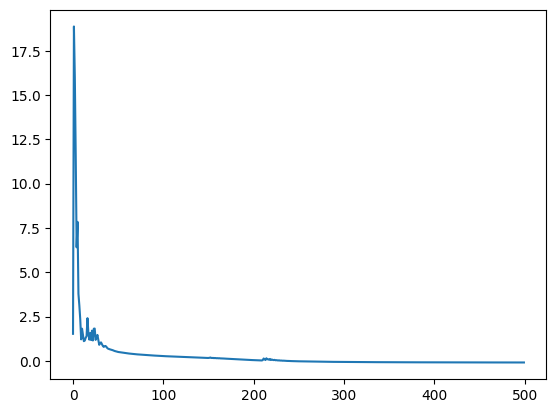

In [17]:
plt.plot(losses)

In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

7it [00:14,  2.00s/it]/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:168: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
8it [00:22,  4.01s/it]W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/tmp/ipykernel_20839/2467812288.py:21)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: L['key'] == '29513-3-5'                                     
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch

In [25]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:09, 22.31it/s]


In [106]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:08, 22.55it/s]


In [30]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = tiny_hiera(videos,);
        if i > 200:
            break

201it [00:03, 52.64it/s]


In [ ]:
opt.zero_grad()


In [193]:
videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)

In [194]:
from torch.amp import autocast

In [182]:
opt_r.to(torch.bfloat16);

In [183]:
with autocast(device_type='cuda', dtype=torch.float16):
    out = opt_r(videos, k);


In [57]:
out.shape

torch.Size([8, 7495, 16])

In [58]:
loss = criteria(out.transpose(1,2), responses)

In [59]:
loss.backward()

In [61]:
opt.step()

In [63]:
opt.zero_grad()

In [65]:
loss.shape

torch.Size([])

In [186]:
videos.shape

torch.Size([8, 1, 16, 144, 256])

In [196]:
opt_r = opt_r.to(torch.bfloat16)

In [197]:
out = opt_r(videos, k);

In [ ]:
out = opt_r(videos, k);

In [ ]:
losses = []
for _ in tqdm(range(1000)):
    #with autocast(device_type='cuda', dtype=torch.bfloat16):
    videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
    responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    out = opt_r(videos, k);
    loss = criteria(out.transpose(1,2), responses)
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())

 58% 576/1000 [01:24<01:01,  6.84it/s]

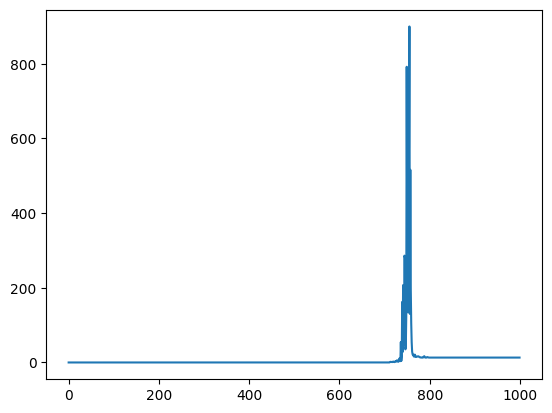

In [218]:
plt.plot(losses)

In [141]:
out.shape

torch.Size([8, 7495, 16])

In [142]:
responses.shape

torch.Size([8, 16, 7495])

In [51]:
neuron=66

0.12096827660364878

In [38]:
out.shape

torch.Size([8, 7495, 16])

In [ ]:
for batch_no, (data_key, data) in tqdm(enumerate(LongCycler(dataloaders["train"])), total=n_iterations,
                                       desc="Epoch {}".format(epoch)):

    loss = full_objective(model, dataloaders["train"], data_key, *data)
    # loss = torch.sum(loss)
    loss.backward()

In [33]:
full_out.shape

torch.Size([8, 7671, 16])

In [ ]:
r.readout["29513-3-5"].bias.shape

In [97]:
full_out = rearrange(full_out, 'b (n t) c -> b t n c', n=7671, t=16)

In [49]:
full_out.shape

torch.Size([8, 16, 7671, 384])

In [50]:
w = r.readout["29513-3-5"].weight

In [51]:
w.shape

torch.Size([7671, 256, 1])

In [54]:
torch.einsum("btni, njr->bnt", full_out, w, )

torch.Size([8, 7671, 16])

In [93]:
full_out.shape

torch.Size([8, 7671, 256])

In [75]:
torch.isnan(full_out).sum()

tensor(960416, device='cuda:0')

In [37]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.38it/s]


In [39]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.43it/s]


In [43]:
for i in tqdm(range(100)):
    r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 103.98it/s]


In [29]:
import torch
n_params=0
for n, p in r.readout.named_parameters():
    print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

29513-3-5.query torch.Size([1, 8, 7671, 32]) 1963776
29513-3-5.weight torch.Size([7671, 256, 1]) 1963776
29513-3-5.bias torch.Size([1, 7671, 1]) 7671
29514-2-9.query torch.Size([1, 8, 7495, 32]) 1918720
29514-2-9.weight torch.Size([7495, 256, 1]) 1918720
29514-2-9.bias torch.Size([1, 7495, 1]) 7495
29755-2-8.query torch.Size([1, 8, 8122, 32]) 2079232
29755-2-8.weight torch.Size([8122, 256, 1]) 2079232
29755-2-8.bias torch.Size([1, 8122, 1]) 8122
29647-19-8.query torch.Size([1, 8, 8202, 32]) 2099712
29647-19-8.weight torch.Size([8202, 256, 1]) 2099712
29647-19-8.bias torch.Size([1, 8202, 1]) 8202
29156-11-10.query torch.Size([1, 8, 7440, 32]) 1904640
29156-11-10.weight torch.Size([7440, 256, 1]) 1904640
29156-11-10.bias torch.Size([1, 7440, 1]) 7440
29623-4-9.query torch.Size([1, 8, 7908, 32]) 2024448
29623-4-9.weight torch.Size([7908, 256, 1]) 2024448
29623-4-9.bias torch.Size([1, 7908, 1]) 7908
29515-10-12.query torch.Size([1, 8, 7863, 32]) 2012928
29515-10-12.weight torch.Size([7863,

In [23]:
full_out.shape

torch.Size([8, 7671, 256])

In [38]:
30684/16

1917.75

In [ ]:
30684

In [35]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

torch.Size([8, 4, 18, 16, 384])
torch.Size([8, 1152, 256])
torch.Size([8, 1152, 256])
torch.Size([32, 8, 7671, 32])
torch.Size([8, 8, 1152, 32])
torch.Size([8, 8, 1152, 32])


In [42]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

100% 100/100 [00:00<00:00, 110.38it/s]


In [20]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        tiny_hiera(example_in);

100% 1000/1000 [00:21<00:00, 46.31it/s]


In [11]:
24*32*16

12288

In [22]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        #tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:17, 17.03it/s]


In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:22, 13.28it/s]


In [25]:
import torch
n_params=0
for n, p in tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4891336


In [2]:
import hiera

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from hiera import Hiera


In [3]:
hiera

<module 'hiera' from '/usr/local/lib/python3.10/dist-packages/hiera/__init__.py'>

In [1]:
from hiera import Hiera
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k_ft_in1k")  # mae pt then in1k ft'd model
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k") # just mae pt, no ft

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Hiera.from_pretrained("facebook/hiera_tiny_224.mae_in1k") # just mae pt, no ft

In [3]:

import torch
from hiera import Hiera
my_tiny_hiera = Hiera(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2))

In [4]:
my_cut_hiera = Hiera(input_size=(16,144, 144),
                     num_heads=1, 
                     stages=(1, 2, 2), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(1, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 7, 7),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)

In [5]:
my_cut_hiera.eval().cuda().to(torch.bfloat16);

In [6]:
from tqdm import tqdm

In [11]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        my_cut_hiera(example_in);

 19% 193/1000 [00:15<01:06, 12.07it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f167ca8b370>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [125]:
out = my_cut_hiera(torch.ones(1,1,16,144,144).cuda(), return_intermediates=True)

In [122]:
(out[1])[1].shape

torch.Size([1, 8, 18, 18, 192])

In [81]:
36*4

144

In [69]:
my_cut_hiera.head.projection.weight.shape

torch.Size([1000, 384])

In [75]:
import numpy as np

In [76]:
np.sqrt(384)

np.float64(19.595917942265423)

In [40]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(413)forward()
    411             else None,
    412         )
--> 413         x = x + self.get_pos_embed()
    414         x = self.unroll(x)
    415 



ipdb>  x.shape


torch.Size([1, 3888, 96])


ipdb>  self.get_pos_embed().shape


torch.Size([1, 10368, 96])


ipdb>  q


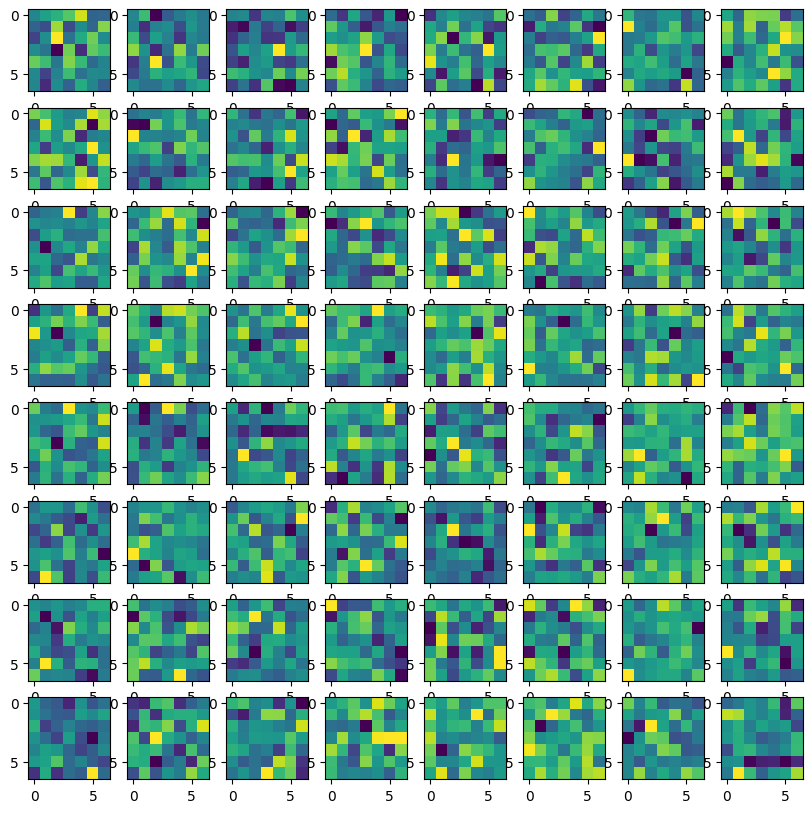

In [83]:
fig, axs = plt.subplots(8,8, figsize=(10,10))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,0].cpu().numpy())

In [2]:
import torch

In [7]:
some_weights = torch.load("mae_hiera_tiny_224.pth")
my_cut_hiera.load_state_dict(some_weights["model_state"], strict=False)


/tmp/ipykernel_248295/1124240724.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  some_weights = torch.load("mae_hiera_tiny_224.pth")


RuntimeError: Error(s) in loading state_dict for Hiera:
	size mismatch for pos_embed: copying a param with shape torch.Size([1, 3136, 96]) from checkpoint, the shape in current model is torch.Size([1, 2304, 96]).

In [ ]:
fig, axs = plt.subplots(8,12, figsize=(12,8))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,2].cpu().numpy(), cmap="hot")
    ax.axis("off")

In [8]:
n_params=0
for n, p in my_tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [9]:
n_params=0
for n, p in model.named_parameters():
    print#(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [10]:
n_params=0
for n, p in my_cut_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4987336


In [11]:
my_cut_hiera.to("cuda", torch.bfloat16);
my_tiny_hiera.to("cuda", torch.bfloat16);


In [12]:
from tqdm import tqdm

In [13]:
with torch.no_grad():
    for i in tqdm(range(100)):
        my_cut_hiera(torch.ones(500,3,256,144).to("cuda", torch.bfloat16));

100% 100/100 [00:16<00:00,  6.09it/s]


In [15]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.48it/s]


In [16]:
my_tiny_hiera = torch.compile(my_tiny_hiera,)

In [9]:
my_tiny_hiera.to("cuda", torch.bfloat16);
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
out = my_tiny_hiera(example, );

In [19]:
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.60it/s]


In [21]:
torch.set_float32_matmul_precision('high')
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.64it/s]


In [22]:
torch.set_float32_matmul_precision('medium')

In [24]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)


100% 100/100 [00:13<00:00,  7.63it/s]


In [30]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [32]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [36]:
torch.backends.cuda.enable_flash_sdp(False)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.46it/s]


In [37]:
torch.backends.cuda.enable_flash_sdp(True)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.37it/s]


In [4]:
import torch

In [15]:
example.shape


torch.Size([500, 3, 224, 224])

In [5]:
torch.__version__

'2.6.0.dev20240913+cu121'

In [14]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(100)forward()
     98         if hasattr(F, "scaled_dot_product_attention"):
     99             # Note: the original paper did *not* use SDPA, it's a free boost!
--> 100             x = F.scaled_dot_product_attention(q, k, v)
    101         else:
    102             attn = (q * self.scale) @ k.transpose(-1, -2)



ipdb>  F


<module 'torch.nn.functional' from '/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py'>


ipdb>  k.shape


torch.Size([500, 1, 49, 64, 96])


ipdb>  q


In [21]:
from tqdm import tqdm
torch.set_float32_matmul_precision('medium')
from torch.nn.attention import SDPBackend, sdpa_kernel
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(torch.ones(10,3,224,224).to("cuda", torch.bfloat16), );

  0% 0/100 [00:00<?, ?it/s]


RuntimeError: No available kernel. Aborting execution.

In [2]:
128*8*3*224*224*2 / 1e9

0.308281344

In [ ]:
! 

In [ ]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))